## Import Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model, layers, models, initializers
from keras.layers import *
from keras.datasets import mnist
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import kagglehub

/opt/homebrew/anaconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Enable GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load the Dataset

In [3]:
# Download the latest version of the CelebA dataset
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# print("Path to dataset files:", path)
path = "/Users/yfahmy/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/"
base_dir = os.path.join(path, "img_align_celeba") 

image_dim = 128
num_channels = 3
images = []

# Optional: limit number of images if needed
MAX_IMAGES = 10000

for i, filename in enumerate(os.listdir(base_dir)):
    if filename.endswith(".jpg"):
        image_path = os.path.join(base_dir, filename)

        try:
            img = Image.open(image_path).convert("RGB")
            img = img.resize((image_dim, image_dim))
            images.append(np.array(img))
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

        if i + 1 >= MAX_IMAGES:
            break

images = np.array(images)

x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(len(x_train), image_dim, image_dim, num_channels)
x_test = x_test.reshape(len(x_test), image_dim, image_dim, num_channels)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (8000, 128, 128, 3), x_test shape: (2000, 128, 128, 3)


## Add Gaussian Blur

In [4]:
def add_gaussian_blur_batch(images, kernel_size=(5, 5), sigma=5.0):
    blurred_images = np.empty_like(images)
    for i in range(images.shape[0]):
        blurred_images[i] = cv2.GaussianBlur(images[i], kernel_size, sigma)
    return blurred_images

x_train_noisy = add_gaussian_blur_batch(x_train)
x_test_noisy = add_gaussian_blur_batch(x_test)

## Add Gaussian Noise

In [5]:
noise_factor = 0.075
x_train_noisy = x_train_noisy + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test_noisy + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

## Add Salt and Pepper Noise

In [6]:
def add_s_and_p_noise_batch(images, salt_prob=0.01, pepper_prob=0.01):
    N, H, W, C = images.shape
    rand_matrix = np.random.rand(N, H, W)
    salt_mask = rand_matrix < salt_prob
    pepper_mask = rand_matrix > (1 - pepper_prob)
    images[salt_mask] = 255
    images[pepper_mask] = 0
    return images

# Disable for now
# x_train_noisy = add_s_and_p_noise_batch(x_train_noisy)
# x_test_noisy = add_s_and_p_noise_batch(x_test_noisy)

In [7]:
# clip the values in the range of 0-1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Exploratory Data Analysis

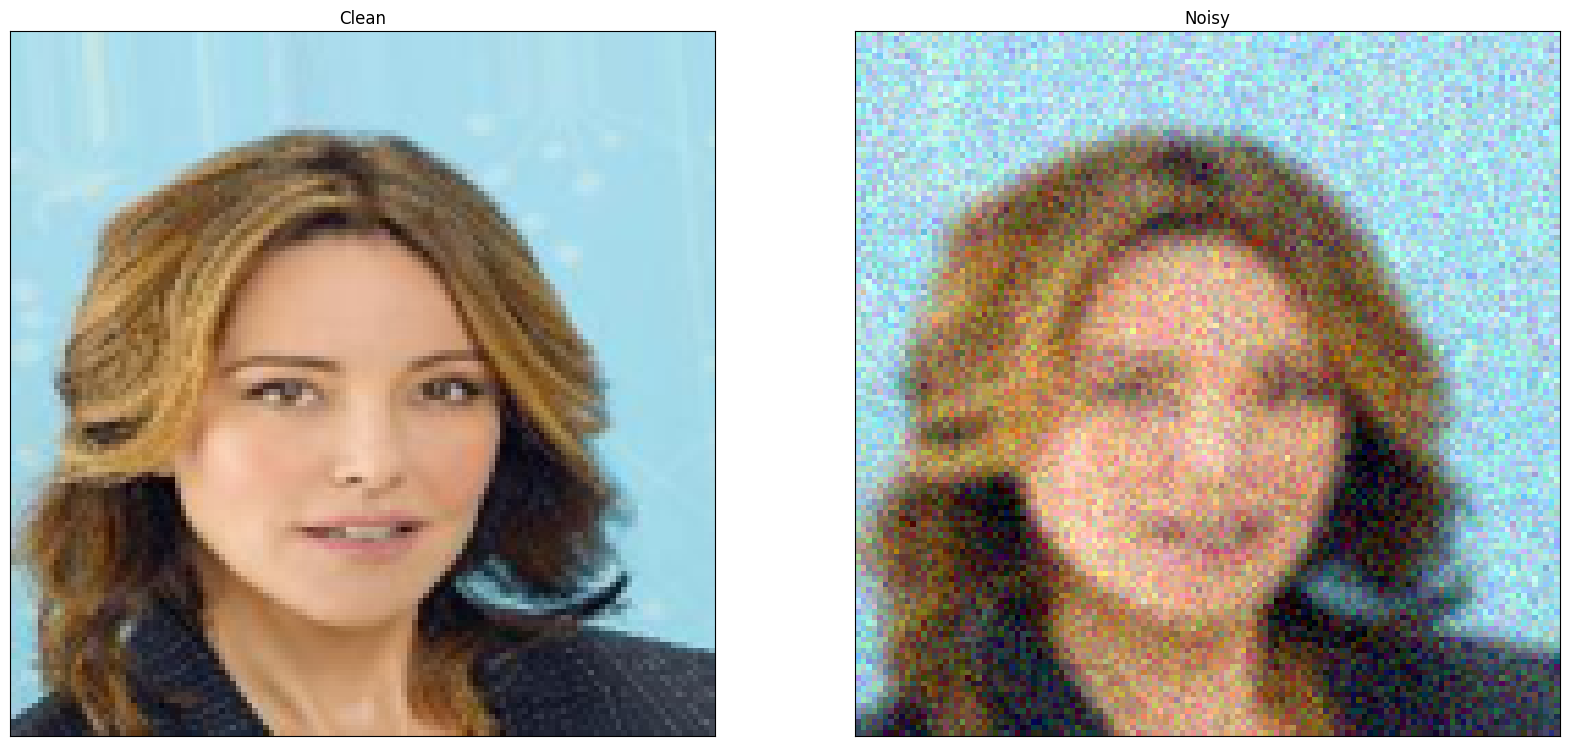

In [8]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
ax = plt.subplot(1, 2, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
plt.show()

## Model Creation

In [9]:
# input_img = Input(shape=(image_dim, image_dim, num_channels))  # RGB images

# # First layer (Conv + ReLU)
# x = Conv2D(64, (3, 3), padding='same')(input_img)
# s1 = ReLU()(x)


# s2 = Conv2D(64, (3, 3), padding='same')(s1)
# s2 = BatchNormalization()(s2)
# s2 = ReLU()(s2)

# x = Conv2D(32, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)

# x = Conv2D(16, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)

# x = Conv2D(16, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)

# x = Conv2D(32, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)

# x = Conv2D(64, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)


# # Last layer (Conv, No Activation)
# x = Conv2D(3, (3, 3), padding='same')(x)

# # Skip Connection (Residual Learning)
# output_img = Add()([input_img, x])

# model = Model(inputs=input_img, outputs=output_img)

# model.compile(optimizer='adam', loss='mse')
# model.summary()
input_img = Input(shape=(image_dim, image_dim, num_channels))  # RGB images

# Initial Conv + ReLU
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

# Downsampling block 1
x1 = Conv2D(64, (3, 3), padding='same')(x)
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)
p1 = MaxPooling2D(pool_size=(2, 2))(x1)

# Downsampling block 2
x2 = Conv2D(64, (3, 3), padding='same')(p1)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)
p2 = MaxPooling2D(pool_size=(2, 2))(x2)

# Middle block 1
x3 = Conv2D(64, (3, 3), padding='same')(p2)
x3 = BatchNormalization()(x3)
x3 = ReLU()(x3)

# Middle block 2
x4 = Conv2D(64, (3, 3), padding='same')(x3)
x4 = BatchNormalization()(x4)
x4 = ReLU()(x4)

# Upsampling block 1 + skip connection with x2
u1 = UpSampling2D(size=(2, 2))(x4)
u1 = Add()([u1, x2])
u1 = Conv2D(64, (3, 3), padding='same')(u1)
u1 = BatchNormalization()(u1)
u1 = ReLU()(u1)

# Upsampling block 2 + skip connection with x1
u2 = UpSampling2D(size=(2, 2))(u1)
u2 = Add()([u2, x1])
u2 = Conv2D(64, (3, 3), padding='same')(u2)
u2 = BatchNormalization()(u2)
u2 = ReLU()(u2)

# Final output layer
output = Conv2D(3, (3, 3), padding='same')(u2)

# Residual connection (input + output)
output_img = Add()([input_img, output])

# Build model
model = Model(inputs=input_img, outputs=output_img)
model.compile(optimizer='adam', loss='mse')
model.summary()

2025-03-29 16:46:04.275417: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-03-29 16:46:04.275440: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-03-29 16:46:04.275443: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-03-29 16:46:04.275462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-29 16:46:04.275471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 226,627 (885.26 KB)

 Trainable params: 225,859 (882.26 KB)

 Non-trainable params: 768 (3.00 KB)

## Train the model

In [10]:
model.fit(x_train_noisy, x_train, epochs=20 , batch_size=64, shuffle=True, validation_data=(x_test_noisy, x_test))
model.save("trained_models/celeba_cnn_unet.keras")

Epoch 1/6


2025-03-29 16:46:07.574032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-29 16:46:07.580751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1264

2025-03-29 16:51:26.977123: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


125/125 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - loss: 0.1257 - val_loss: 0.0078
Epoch 2/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - loss: 0.0044 - val_loss: 0.0061
Epoch 3/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - loss: 0.0034 - val_loss: 0.0045
Epoch 4/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - loss: 0.0030 - val_loss: 0.0037
Epoch 5/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - loss: 0.0028 - val_loss: 0.0032
Epoch 6/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - loss: 0.0027 - val_loss: 0.0033


## Visualize the Results

In [11]:
# predict the results from model (get compressed images)
pred = model.predict(x_test_noisy)

 1/63 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step

2025-03-29 17:18:23.678098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12961447..1.0160272].


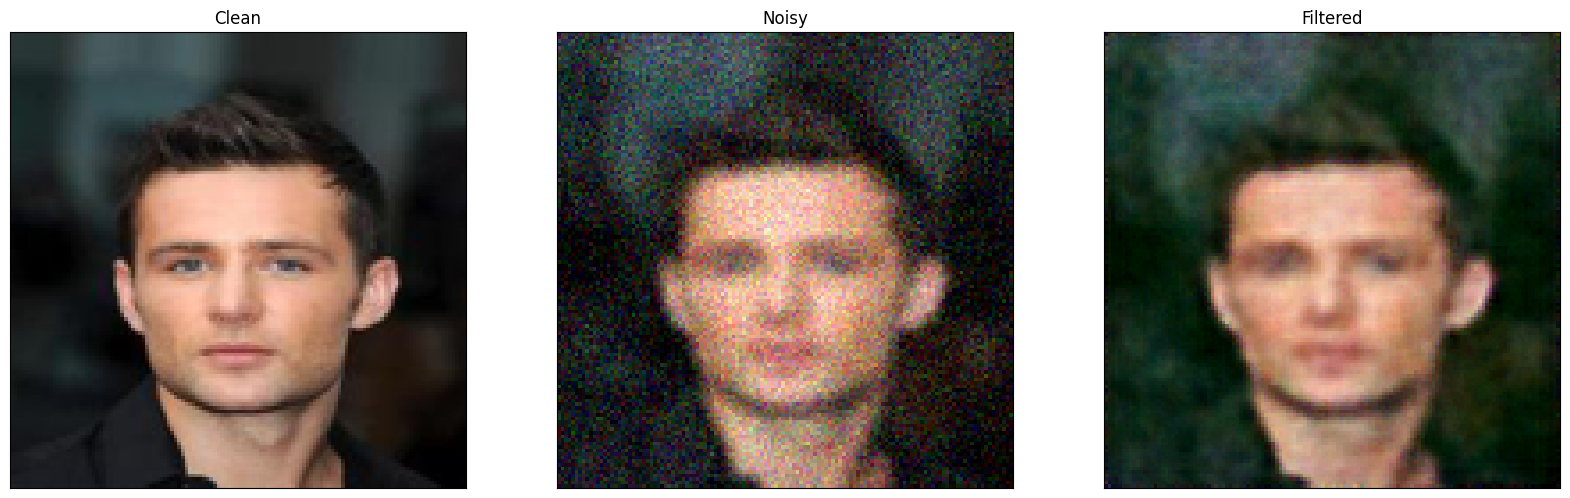

In [12]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 3, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 3, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
# display cleaned image
ax = plt.subplot(1, 3, 3)
plt.imshow(pred[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Filtered")
plt.show()

## Evaluate the Model

In [13]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Generate model predictions
x_pred = model.predict(x_test_noisy)

# Clip to valid range (e.g. 0-1 or 0-255 depending on preprocessing)
x_pred = np.clip(x_pred, 0, 1)
x_test = np.clip(x_test, 0, 1)

# Calculate average PSNR and SSIM
psnr_total = 0
ssim_total = 0
for i in range(len(x_test)):
    psnr_total += psnr(x_test[i], x_pred[i], data_range=1.0)
    ssim_total += ssim(x_test[i], x_pred[i], channel_axis=-1, data_range=1.0)

avg_psnr = psnr_total / len(x_test)
avg_ssim = ssim_total / len(x_test)

print("Avg PSNR:", avg_psnr)
print("Avg SSIM:", avg_ssim)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Avg PSNR: 25.087997617854995
Avg SSIM: 0.7174473918676376
